<a href="https://colab.research.google.com/github/Saifullah785/deep-learning-projects/blob/main/Project_14_flickr8k_Image_Caption_Generator/Project_14_flickr8k_Image_Caption_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries and configure plotting settings
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling1D, GlobalMaxPooling2D, Activation, Dropout, Flatten, Dense, Input,Layer
from tensorflow.keras.layers import Embedding, LSTM, Add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style('dark')
warnings.filterwarnings('ignore')

**Image** **Captioning**

In [39]:
import os

# Set Kaggle configuration directory to find kaggle.json
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'

# Download the dataset
!kaggle datasets download -d adityajn105/flickr8k

# Unzip the dataset
!unzip -q flickr8k.zip -d flickr8k

# Verify the contents (optional, but good for debugging)
!ls flickr8k

In [3]:
# Update the image_path and load the captions.txt file
image_path = './flickr8k/Images'
data = pd.read_csv("./flickr8k/captions.txt")
display(data.head())

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

**visualization**

In [4]:
# Define utility functions for image reading and display
def readImage(path, img_size=224):
  img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
  img = img_to_array(img)
  img = img/255
  return img

def display_images(temp_df):
  temp_df = temp_df.reset_index(drop=True)
  plt.figure(figsize= (20, 20))
  n = 0
  for i in range(15):
    n+=1
    plt.subplot(5, 5, n)
    plt.subplots_adjust(hspace=0.7, wspace=0.3)
    image = readImage(f"{image_path}/{temp_df.image[i]}")
    plt.imshow(image)
    plt.title("\n".join(wrap(temp_df.caption[i], 20)))
    plt.axis('off')

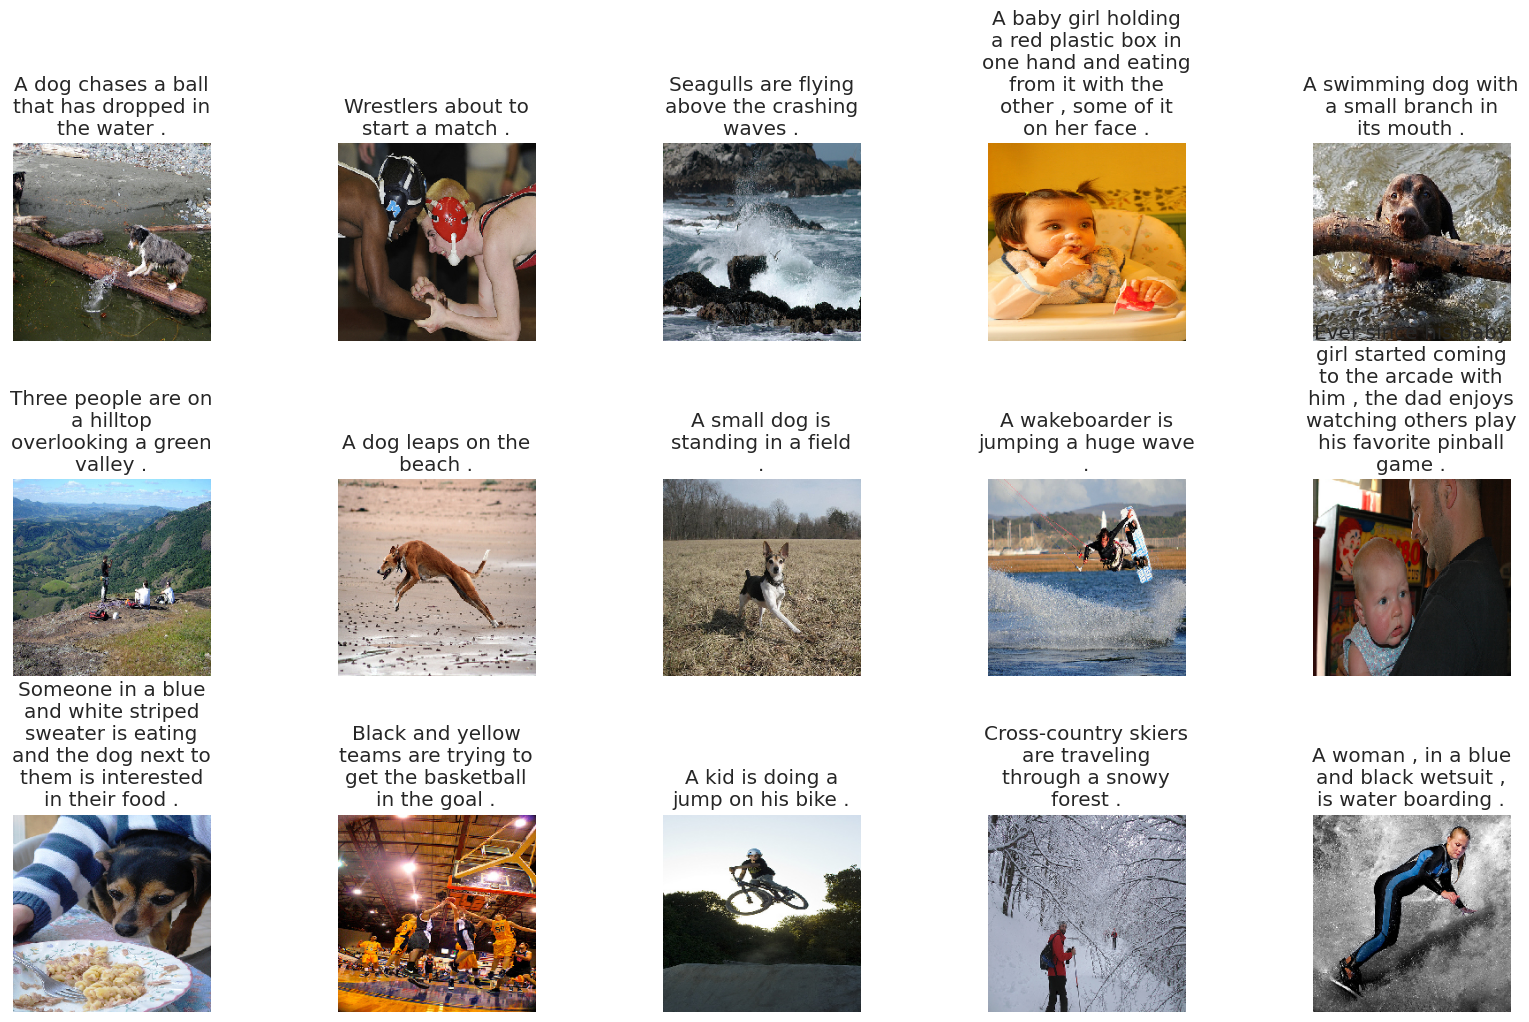

In [5]:
# Display a sample of images with their captions
display_images(data.sample(15))

# **Caption Text Preprocesssing Steps**

In [6]:
# Define and apply text preprocessing to captions
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"

    return data

data = text_preprocessing(data)

captions = data['caption'].tolist()

captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

# Tokenization and Encoded Representation

In [7]:
# Initialize tokenizer and split data into training and validation sets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

# **Images Feature Extraction**

In [8]:
# Extract image features using a pre-trained DenseNet201 model
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


100%|██████████| 8091/8091 [13:14<00:00, 10.18it/s]


# Data Generation

In [14]:
# Define a custom data generator for training the image captioning model
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

In [15]:
# Initialize training and validation data generators
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [16]:
# Access the first batch of data from the training generator
train_generator[0]

((array([[7.8687917e-05, 7.3524064e-04, 1.1395991e-03, ..., 5.6523490e-01,
          2.2903672e-01, 6.9639724e-01],
         [7.8687917e-05, 7.3524064e-04, 1.1395991e-03, ..., 5.6523490e-01,
          2.2903672e-01, 6.9639724e-01],
         [7.8687917e-05, 7.3524064e-04, 1.1395991e-03, ..., 5.6523490e-01,
          2.2903672e-01, 6.9639724e-01],
         ...,
         [1.9476042e-04, 7.0213038e-04, 1.4947484e-03, ..., 2.7233811e-02,
          5.5759621e-01, 3.8916752e-01],
         [1.9476042e-04, 7.0213038e-04, 1.4947484e-03, ..., 2.7233811e-02,
          5.5759621e-01, 3.8916752e-01],
         [1.9476042e-04, 7.0213038e-04, 1.4947484e-03, ..., 2.7233811e-02,
          5.5759621e-01, 3.8916752e-01]], dtype=float32),
  array([[  0,   0,   0, ...,   0,   0,   1],
         [  0,   0,   0, ...,   0,   1,  42],
         [  0,   0,   0, ...,   1,  42,   3],
         ...,
         [  0,   0,   0, ...,  10,  76,  49],
         [  0,   0,   0, ...,  76,  49,   4],
         [  0,   0,   0, ...,


#**Modelling**

In [21]:
# Define and compile the image captioning model architecture
from tensorflow.keras.utils import plot_model

input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = Add()([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')


from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model checkpoint
model_name = "model.keras"  # Update the extension to .keras
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)



history = caption_model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/10
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 5.6890
Epoch 1: val_loss improved from inf to 4.29048, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 80s 147ms/step - loss: 5.6879 - val_loss: 4.2905 - learning_rate: 0.0010
Epoch 2/10
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 4.3526
Epoch 2: val_loss improved from 4.29048 to 3.97741, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 78s 145ms/step - loss: 4.3525 - val_loss: 3.9774 - learning_rate: 0.0010
Epoch 3/10
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 4.0367
Epoch 3: val_loss improved from 3.97741 to 3.81561, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 77s 144ms/step - loss: 4.0367 - val_loss: 3.8156 - learning_rate: 0.0010
Epoch 4/10
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 3.8372
Epoch 4: val_loss improved from 3.81561 to 3.74469, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 76s 142ms/step - loss: 3.8372 - val_loss: 3.7447 - learning_rate: 0.0010


# **Learning Curve**

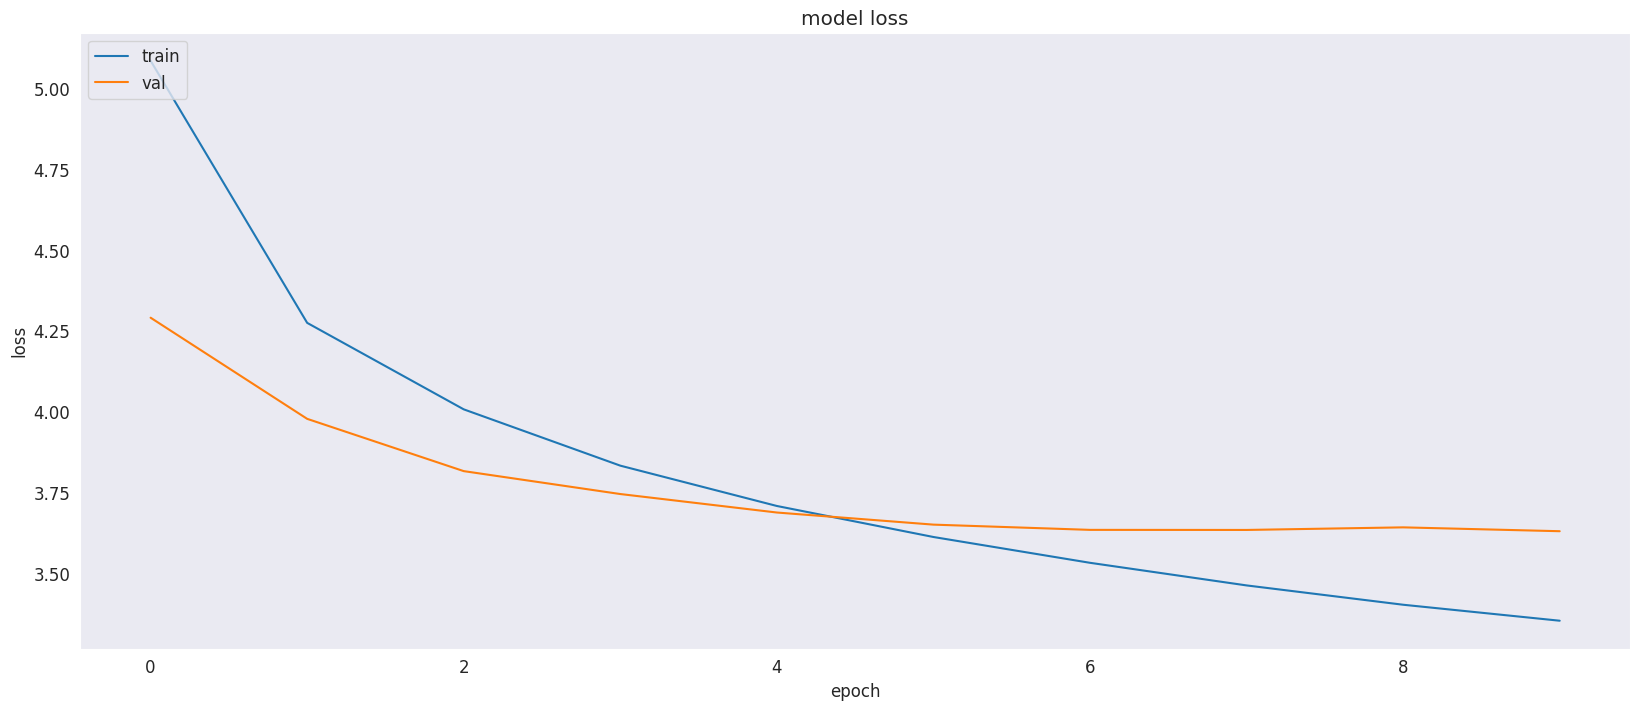

In [22]:
# Plot the training and validation loss curves
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **Caption Generation Utility Functions**


In [24]:
# Save the tokenizer and feature extractor model
import pickle

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save the feature extractor model
fe.save("feature_extractor.keras")

In [35]:
# Import necessary libraries and define paths for saved model artifacts
# Define a function to generate and display captions for a given image
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

# load save files
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"


def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34, img_size=224):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)  # Extract image features

    # Generate the caption
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # Display the image with the generated caption
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()

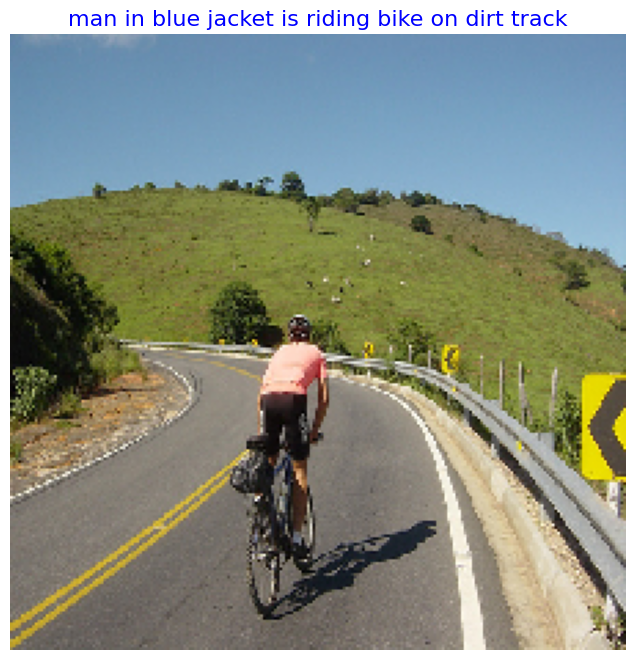

In [36]:
# Example usage
image_path = "./flickr8k/Images/110595925_f3395c8bd6.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

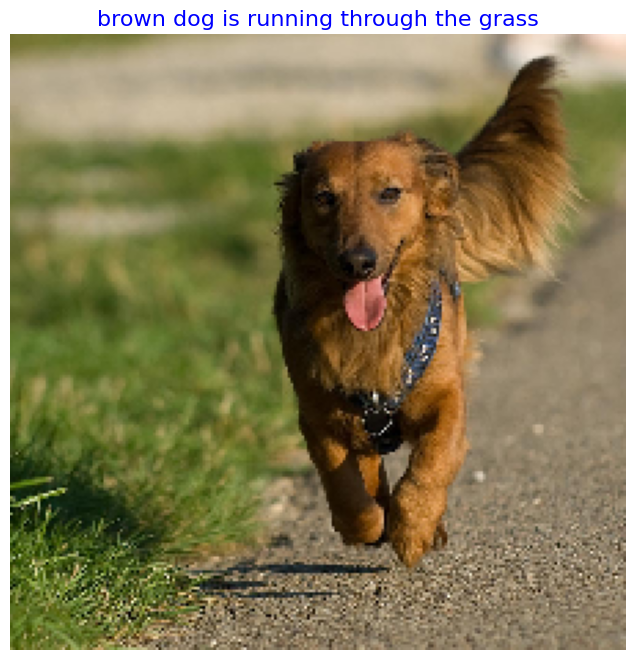

In [37]:
# Generate and display caption for another example image

image_path = "./flickr8k/Images/1089181217_ee1167f7af.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

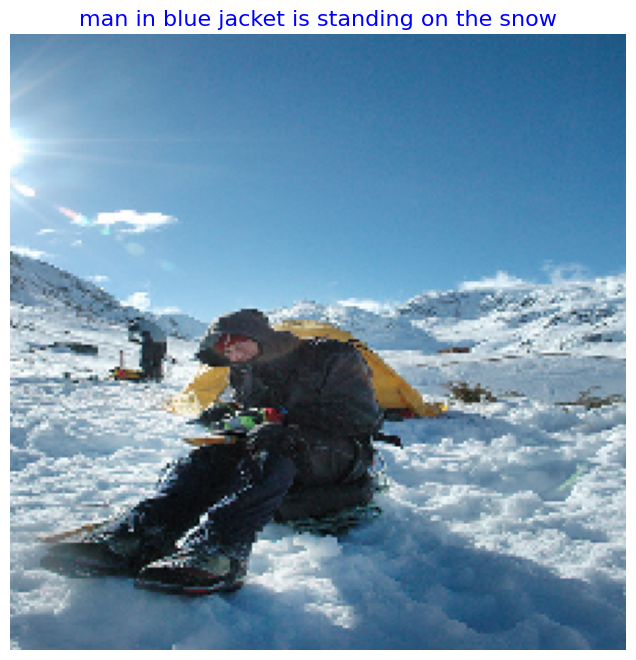

In [38]:
# Generate and display caption for a third example image
image_path = "./flickr8k/Images/116409198_0fe0c94f3b.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)